# Comparison of Recommendation Systems on Amazon Review DataSet

Raj Sundhar Ravichandran rr966<br/>Abishek Prasanna ap1534

**Summary**<br/>The purpose of this project is to understand the advantages and disadvantages of various recommendation systems, thus in turn understanding how the recommendation systems are chosen for various use cases in the industry. This project is heavily influenced by the Netflix Prize open competition. We chose Amazon open dataset, as it is already collected and is readily available for research. We got the data from http://jmcauley.ucsd.edu/data/amazon/. This dataset contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 – July 2014. The product reviews data contains information about ratings, text, helpfulness votes and the metadata contains information about descriptions, category information, price, brand and image features.<br/><br/>**Introduction**<br/>From Amazon recommending products you may be interested in based on your recent purchases to Netflix recommending shows and movies you may want to watch; recommender systems have become popular across many applications of data science. Like many other problems in data science, there are several ways to approach recommendations. Two of the most popular are collaborative filtering and content-based recommendations. In Collaborative Filtering, for each user, recommender systems recommend items based on how similar users liked the item. In Content-based recommendation, recommender systems work based on the detailed metadata about each item. We build an item profile for each item and based on this item profile, recommendations are provided.
We have explored various recommendation systems in both Content-based recommendation and Collaborative Filtering. The recommendation techniques tried and tested are: mean, median, baseline, Un-Weighted Cosine Similarity, Weighted Cosine Similarity, K-Nearest Neighbors (KNN), Single Value Decomposition (SVD), Alternative Least Squares (ALS), Dimension Independent Matrix Square using MapReduce (DIMSUM). Let us explore the Root Mean Square Error (RMSE) for each of the above-mentioned algorithms, as it aids in easier comparison of effective algorithms.

In [1]:
import numpy as np
import _pickle as pickle
from collections import Counter
from os import path
import pandas as pd
import gzip
import math
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix, csc_matrix
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col, countDistinct
from pyspark.mllib.linalg.distributed import CoordinateMatrix, MatrixEntry
from pyspark.sql.functions import mean, avg, min, max
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import Matrices

data_repo_path = ""
data_loc = data_repo_path + "kcore_5.json.gz"
pd_ratingdata_pkl = path.join(data_repo_path, 'pd_ratingdata_pkl.pkl')
sparse_matrix_pkl = path.join(data_repo_path, 'sparse_matrix_pkl.pkl')
limited_pd_ratingdata_pkl = path.join(data_repo_path, 'limited_pd_ratingdata_pkl.pkl')
limited_sparse_matrix_pkl = path.join(data_repo_path, 'limited_sparse_matrix_pkl.pkl')

In [2]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import SQLContext

conf = SparkConf()
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '50G')
        .set('spark.driver.memory', '30G')
        .set('spark.driver.maxResultSize', '15G')
       )
sc   = SparkContext(conf=conf)
spark = SparkSession(sc)

sqlContext = SQLContext(sc)

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path, exit):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = [d['asin'], d['reviewerID'], d['overall']]
        i += 1
        if i>=exit:
            break
        if i%500000 == 0:
            print(i)
    return pd.DataFrame.from_dict(df, orient='index')

In [4]:
readData = False

In [5]:
if(readData):
    df = getDF(data_loc, math.inf)
    df.columns = ['productID', 'reviewerID', 'overall']
    df.to_pickle(pd_ratingdata_pkl)
else:
    df = pd.read_pickle(pd_ratingdata_pkl)
    
df.head(5)

,productID,reviewerID,overall
0,0000013714,ACNGUPJ3A3TM9,4.0
1,0000013714,A2SUAM1J3GNN3B,5.0
2,0000013714,APOZ15IEYQRRR,5.0
3,0000013714,AYEDW3BFK53XK,5.0
4,0000013714,A1KLCGLCXYP1U1,3.0


In our data most of the products have either no rating or only one rating and most of the users have given no rating or a maximum of one rating. With these data we get to a cold start problem. We don’t have enough data to give predictions to these users and items. Therefore, on a safer side we took only the users whom have given a minimum of 5 ratings and the items which have a minimum of 5 ratings. We call these as 5-core data. Overall, we have 41 million such ratings.

In [6]:
print("Number of unique products =", len(df['productID'].unique()))
print("Number of unique users =", len(df['reviewerID'].unique()))
print("Number of ratings =", len(df))

Number of unique products = 1569973
Number of unique users = 3035045
Number of ratings = 41135700


### Mean, Median
Before we start working on the data, it’s important that we analyze the data and have an overview about them. Let us have some statistical overview of all the ratings. As we can see in the below figure, most of the ratings are 5/5. There has been a study on the psychological behavior of a human on rating an item. A person by default gives a rating of 5 even if he/she is not highly satisfied, they give lesser ratings only if they are unsatisfied with the item. That’s why in some cases the ratings are fixed on a scale of -2 to 2; 0 being the baseline. It gives us better scale to work on our recommendations. Also, the number of users who have given a mean rating of 5 is higher compared to the other users and it holds same for items as well with higher number of items with mean rating of about 5.


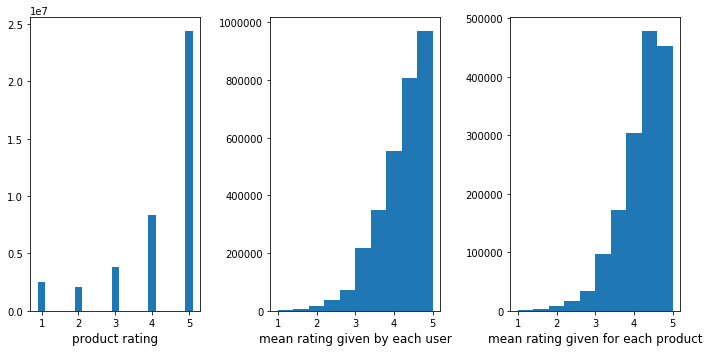

In [7]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(131)
ax.hist(df['overall'], bins=[0.9, 1.1, 1.9, 2.1, 2.9, 3.1, 3.9, 4.1, 4.9, 5.1])
ax.set_xlabel('product rating', fontsize=12)

# mean ratings from each user
mean_rating_of_user = df.groupby('reviewerID').apply(lambda x: x['overall'].mean())
ax = fig.add_subplot(132)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating given by each user', fontsize=12)


# mean ratings from each product
mean_rating_of_product = df.groupby('productID').apply(lambda x: x['overall'].mean())
ax = fig.add_subplot(133)
ax.hist(mean_rating_of_product)
ax.set_xlabel('mean rating given for each product', fontsize=12)


plt.tight_layout()
plt.show()

A simpler and easier way to implement recommendation system is to give recommendations based on the mean and/or median rating values. We calculate the mean/median of all the ratings that we have in our system and give that value as the predicted rating for unknown user – item pairs. It’s evident to assume that this method of recommendation would not fair well. 

In [7]:
mean_score = df['overall'].mean()
median_score = df['overall'].median()

print("Mean Score ", mean_score)
print("Median Score ", median_score)

Mean Score  4.215769635620641
Median Score  5.0


The mean score of all the ratings is 4.21 and the median score is 5. That means more than 50% of the items are rated 5. When we use these scores as the predicted rating score for all the user-item pair, then we get the Root Mean Square Error (RMSE) value as follows:

In [8]:
mean_rmse_benchmark = np.sqrt(pow(df['overall'] - mean_score, 2).mean())
print("Root-mean-square error for mean score = {:4.2f}".format(mean_rmse_benchmark))

median_rmse_benchmark = np.sqrt(pow(df['overall'] - median_score, 2).mean())
print("Root-mean-square error for median score = {:4.2f}".format(median_rmse_benchmark))

Root-mean-square error for mean score = 1.18
Root-mean-square error for median score = 1.42


As we can see the RMSE value is very high which is not a good recommendation system. But it gives us a good baseline score to compare and see how the other recommendation systems perform.

### SUPRISE Package

In [9]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, KFold
from surprise import Dataset, evaluate
from surprise import KNNBasic
from surprise import SVD, SlopeOne, CoClustering
from surprise import accuracy

In [10]:
if(readData):
    limited_df = getDF(data_loc, 35000)
    limited_df.columns = ['productID', 'reviewerID', 'overall']
    limited_df.to_pickle(limited_pd_ratingdata_pkl)
else:
    limited_df = pd.read_pickle(limited_pd_ratingdata_pkl)
    
limited_df.head(5)

,productID,reviewerID,overall
0,0000013714,ACNGUPJ3A3TM9,4.0
1,0000013714,A2SUAM1J3GNN3B,5.0
2,0000013714,APOZ15IEYQRRR,5.0
3,0000013714,AYEDW3BFK53XK,5.0
4,0000013714,A1KLCGLCXYP1U1,3.0


### Cosine Similarity

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. When two vectors are same we get a cosine similarity value of 1 as the angle between them is 0⁰ and if the vectors are completely different from each other, then the cosine similarity value is 0 as the angle between them is 90⁰. The vectors are similar if they are parallel and dissimilar if they are perpendicular to each other. The cosine similarity between user and user is the normalized dot product of their row vectors, A and B respectively in the rating matrix R,
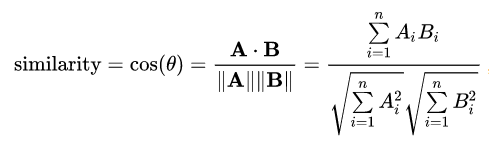
The Root mean square error we get using this unweighted cosine similarity method is, 1.23. This means that for all the ratings that we predict, we are still off by 1 rating. This is still bad, we would like to get as close as the original rating. If we compare this with the baseline score of mean, which is 1.18, we get a poor performance.

In [11]:
df['reviewerID'] = df['reviewerID'].astype("category")
df['productID'] = df['productID'].astype("category")

if(readData):
    csr_reviews_matrix = csr_matrix((df['overall'].astype(float), 
                   (df['reviewerID'].cat.codes,
                    df['productID'].cat.codes 
                    )))
    user_user_similarity = cosine_similarity(csr_reviews_matrix)
    user_user_similarity.shape
    with open(sparse_matrix_pkl, 'wb') as f:
        pickle.dump((csr_reviews_matrix, user_user_similarity), f, -1)

else:
    with open(sparse_matrix_pkl, 'rb') as f:
        csr_reviews_matrix, user_user_similarity = pickle.load(f)  

In [12]:
df.head()

,productID,reviewerID,overall
0,0000013714,ACNGUPJ3A3TM9,4.0
1,0000013714,A2SUAM1J3GNN3B,5.0
2,0000013714,APOZ15IEYQRRR,5.0
3,0000013714,AYEDW3BFK53XK,5.0
4,0000013714,A1KLCGLCXYP1U1,3.0


### Cosine Similarity - UnWeighted

In [61]:
sqdiffs = 0
num_preds = 0
cnt_no_other_ratings = 0

# for each user
for user_i, non_zero_entries in enumerate(reviews_matrix):

    for product in non_zero_entries.indices:
        
        # all users that have rated imovie (includes user of interest)
        i_has_rated = reviews_matrix[:,product].indices
        
        # remove the current user 
        iremove = np.argmin(abs(i_has_rated - user_i)) 
        i_others_have_rated = np.delete(i_has_rated, iremove)
        
        try:
            # find most similar user that has also rated imovie to current user
            i_most_sim = np.argmax(user_user_similarity[user_i, i_others_have_rated])
        except:
            cnt_no_other_ratings += 1
            continue
        
        # prediction error
        predicted_rating = reviews_matrix[i_others_have_rated[i_most_sim], product]
        
        actual_rating = reviews_matrix[user_i, product]
        
        sqdiffs += pow(predicted_rating-actual_rating, 2.)
        num_preds += 1
        
rmse_cossim = np.sqrt(sqdiffs/num_preds)   

print("Mean square error from cosine similarity is ", str(rmse_cossim))

Mean square error from cosine similarity is  1.23891326271


### Cosine Similarity - Weighted

The major drawback of using unweighted cosine similarity is that, we give equal weight to all the items while calculating the similarity. We can make this work better by giving more weight to the most similar items, this way we can achieve higher efficiency. We get RMSE score of 1.02 for this method. We can see a considerable improvement in the RMSE score.

In [63]:
sqdiffs = 0
num_preds = 0

# to protect against divide by zero issues
eps = 1e-6

cnt_no_sims = 0

# for each user
for user_i, non_zero_entries in enumerate(reviews_matrix):
    
    # for each rated movie: find users who HAVE ALSO rated this movie
    for product in non_zero_entries.indices:
                
        # all users that have rated imovie (includes user of interest)
        i_has_rated = reviews_matrix[:,product].indices
        
        # remove the current user 
        #print i_has_rated, user_i
        iremove = np.argmin(abs(i_has_rated - user_i)) 
        i_others_have_rated = np.delete(i_has_rated, iremove)
        
        
        # rating is weighted sum of all ratings, weights are cosine sims
        ratings = reviews_matrix[i_others_have_rated, product]
        sims = user_user_similarity[user_i, i_others_have_rated]
        
        
        norm = np.sum(sims) # calculate the weighting parameter
        
        if norm==0:
            cnt_no_sims += 1
            norm = eps
        
        predicted_rating = np.sum(np.multiply(ratings.A.T, sims))/norm
        
        # prediction error
        actual_rating = reviews_matrix[user_i, product]
        
        sqdiffs += pow(predicted_rating-actual_rating, 2.)
        num_preds += 1
        

rmse_cossim_weighted = np.sqrt(sqdiffs/num_preds)

print("Mean root mean square error from weighted method is =", rmse_cossim_weighted)

Mean root mean square error from weighted method is = 1.02082452672


### Top N Cosine Similarity

We could consider only N most similar items while predicting rating for an item. When we compare by taking different value for N in top N most similar items, we get different RMSE values. By plotting them into a graph, we can see that the RMSE value reduces exponentially till 20 most similar items and then it stretches out to a straight line. Taking the 20 most similar items gives us a better RMSE value with good performance trade-off, which has a RMSE value of 1.025. 

In [ ]:
def rmse_topN(topN):
    """Return the root-mean-square-error given value topN
       for using the 'top N' most similar users in predicting
       the rating
       
       :input: int
       :output: float
    """
    sqdiffs = 0
    num_preds = 0

    # to protect against divide by zero issues
    eps = 1e-6

    cnt_no_sims = 0
    # for each user
    for user_i, non_zero_entries in enumerate(reviews_matrix):

        # for each rated movie: find users who HAVE ALSO rated this movie
        for product in non_zero_entries.indices:

            # all users that have rated imovie (includes user of interest)
            i_has_rated = reviews_matrix[:,product].indices

            # remove the current user 
            #print i_has_rated, user_i
            iremove = np.argmin(abs(i_has_rated - user_i)) 
            i_others_have_rated = np.delete(i_has_rated, iremove)


            # rating is weighted sum of all ratings, weights are cosine sims
            ratings = reviews_matrix[i_others_have_rated, product].A
            sims = user_user_similarity[user_i, i_others_have_rated]
            
            #choose top N most similar users
            most_similar_users = sims[np.argsort(sims*-1)][:topN]
            most_similar_ratings = ratings[np.argsort(sims*-1)][:topN]


            norm = np.sum(most_similar_users)
            if norm==0:
                cnt_no_sims += 1
                norm = eps

            predicted_rating = np.sum(np.multiply(most_similar_ratings.T, most_similar_users))/norm

            # prediction error
            actual_rating = reviews_matrix[user_i, product]

            sqdiffs += pow(predicted_rating-actual_rating, 2.)
            num_preds += 1


    rmse_cossim = np.sqrt(sqdiffs/num_preds)
    
    print("Using top", topN , "most similar users to predict rating")
    print("Root mean square error =", rmse_cossim , '\n')
    return rmse_cossim

In [65]:
topN_trials = [2, 5, 10, 20, 30, 50]
rmse_results = []
for topN in topN_trials:
    rmse_results.append(rmse_topN(topN))

Using top 2 most similar users to predict rating
Root mean square error = 1.12029679907 

Using top 5 most similar users to predict rating
Root mean square error = 1.0492650652 

Using top 10 most similar users to predict rating
Root mean square error = 1.03200786291 

Using top 20 most similar users to predict rating
Root mean square error = 1.02548723067 

Using top 30 most similar users to predict rating
Root mean square error = 1.02340132727 

Using top 50 most similar users to predict rating
Root mean square error = 1.02119511305 



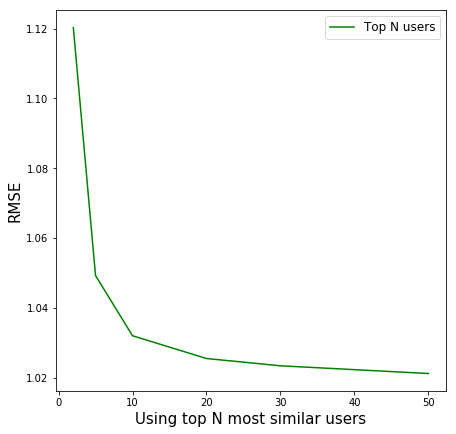

In [71]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

ax.plot(topN_trials, rmse_results, label='Top N users', color='green')
xlims = ax.get_xlim()

ax.set_xlabel('Using top N most similar users', fontsize=15)
ax.set_ylabel('RMSE', fontsize=15)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=12)

### SVD

In linear algebra, the Singular-valued decomposition is a factorization of a real or complex matrix. It gives us values in the order of most significant components, so that we can ignore the least significant components. By splitting the input data into 5 folds of training data, we get the RMSE value as follows. The mean RMSE value that we got with SVD method of recommendation is 1.06.

In [19]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(limited_df[['productID', 'reviewerID', 'overall']], reader)
algoSVD = SVD()
cross_validate(algoSVD, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0952  1.0532  1.0668  1.0658  1.0619  1.0686  0.0142  
MAE (testset)     0.8382  0.8145  0.8264  0.8220  0.8209  0.8244  0.0079  
Fit time          1.97    1.98    1.99    1.97    2.20    2.02    0.09    
Test time         0.05    0.05    0.05    0.05    0.05    0.05    0.00    


{'fit_time': (1.9717929363250732,
  1.9789416790008545,
  1.9922420978546143,
  1.96553635597229,
  2.202246904373169),
 'test_mae': array([0.83818047, 0.81445742, 0.82637037, 0.82203162, 0.82085567]),
 'test_rmse': array([1.09522856, 1.05321412, 1.06675324, 1.06579414, 1.06187521]),
 'test_time': (0.04606342315673828,
  0.04612374305725098,
  0.04752802848815918,
  0.04716825485229492,
  0.050580501556396484)}

By splitting the input data into train and test data set and into 3 Folds, we get the RMSE value as follows:

In [22]:
kf = KFold(n_splits=3)
algoSVD2 = SVD()

for trainset, testset in kf.split(data):
    # train and test algorithm.
    algoSVD2.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8226
RMSE: 0.8223
RMSE: 0.8301


The predicted rating for the user “0000013714” and item “A3W2PX96K1BA3M” is 4.33.

In [33]:
algoSVD.predict("0000013714", "A3W2PX96K1BA3M", 4)

Prediction(uid='0000013714', iid='A3W2PX96K1BA3M', r_ui=4, est=4.333171470890359, details={'was_impossible': False})

### KNN - Cosine Similarity

KNNs are like top-N cosine similarities, they calculate the similarity and take the k-most similar items for recommendation. The SURPRISE package gives us an easier way of implementing KNN recommendation systems using cosine similarity. We divide the data into 2 parts: train and test. We fit the KNN model using the train data and then use the trained model on the test data to make predictions.

In [25]:
trainingSet = data.build_full_trainset()
sim_options = {
    'name': 'cosine',
    'user_based': False
}
knn = KNNBasic(sim_options=sim_options)

knn.fit(trainingSet)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [26]:
testSet = trainingSet.build_anti_testset()
predictions = knn.test(testSet)

Predicted ratings for few user – item pairs are as follows:

In [31]:
print(predictions[1:100])

[Prediction(uid='0000013714', iid='A3W2PX96K1BA3M', r_ui=4.232742857142857, est=4.232742857142857, details={'reason': 'Not enough neighbors.', 'was_impossible': True}), Prediction(uid='0000013714', iid='A2GKR2Q7MD8DG4', r_ui=4.232742857142857, est=4.232742857142857, details={'reason': 'Not enough neighbors.', 'was_impossible': True}), Prediction(uid='0000013714', iid='A1MC4E00RO5E9T', r_ui=4.232742857142857, est=4.232742857142857, details={'reason': 'Not enough neighbors.', 'was_impossible': True}), Prediction(uid='0000013714', iid='A23PISU0ZLW71C', r_ui=4.232742857142857, est=4.232742857142857, details={'reason': 'Not enough neighbors.', 'was_impossible': True}), Prediction(uid='0000013714', iid='A2G0LNLN79Q6HR', r_ui=4.232742857142857, est=4.232742857142857, details={'reason': 'Not enough neighbors.', 'was_impossible': True}), Prediction(uid='0000013714', iid='A2R3K1KX09QBYP', r_ui=4.232742857142857, est=4.232742857142857, details={'reason': 'Not enough neighbors.', 'was_impossible':

In [34]:
accuracy.rmse(predictions, verbose=True)

RMSE: 0.3315


0.3315012925059816

### Top N Recommendations

In [35]:
from collections import defaultdict

def get_topN_recommendations(predictions, topN):
    top_recs = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_recs[uid].append((iid, est))
    for uid, user_ratings in top_recs.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_recs[uid] = user_ratings[:topN]
    return top_recs

Using this model, we can get top N recommended items for each user. The user “0000013714” would get “A14A5Q8VJK5NLR”, “A3W2PX96K1BA3M” and “A2GKR2Q7MD8DG4” as the 3 recommendations based on his rating history.

In [36]:
get_topN_recommendations(predictions, 3)

defaultdict(list,
            {'0000013714': [('A14A5Q8VJK5NLR', 4.232742857142857),
              ('A3W2PX96K1BA3M', 4.232742857142857),
              ('A2GKR2Q7MD8DG4', 4.232742857142857)],
             '0000029831': [('ACNGUPJ3A3TM9', 4.232742857142857),
              ('A2SUAM1J3GNN3B', 4.232742857142857),
              ('APOZ15IEYQRRR', 4.232742857142857)],
             '0000031887': [('A1K1JW1C5CUSUZ', 5),
              ('A1Z54EM24Y40LL', 5),
              ('A6HXFDIC7DVTC', 5)],
             '0000032050': [('ACNGUPJ3A3TM9', 4.232742857142857),
              ('A2SUAM1J3GNN3B', 4.232742857142857),
              ('APOZ15IEYQRRR', 4.232742857142857)],
             '0000230022': [('A1CP960DFEHZ5H', 5),
              ('A10000012B7CGYKOMPQ4L', 5),
              ('A2S166WSCFIFP5', 5)],
             '0000589012': [('ACNGUPJ3A3TM9', 4.232742857142857),
              ('A2SUAM1J3GNN3B', 4.232742857142857),
              ('APOZ15IEYQRRR', 4.232742857142857)],
             '000100039X': [('A1TB

### Slope-One

It is a simple yet accurate Collaborative Filtering recommendation technique, which drastically reduces overfitting, improve performance and ease implementation. Essentially, instead of using linear regression from one item's ratings to another item's ratings [f(x)=ax+b)], it uses a simpler form of regression with a single free parameter [f(x)=x+b]. The free parameter is then simply the average difference between the two items' ratings. It was shown to be much more accurate than linear regression in some instances, and it takes half the storage or less. For better understanding, let us consider the below scenario:
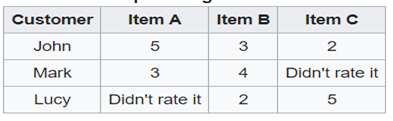

In this case, the average difference in ratings between item B and A is (2+(-1))/2=0.5. Hence, on average, item A is rated above item B by 0.5. Similarly, the average difference between item C and A is 3. Hence, if we attempt to predict the rating of Lucy for item A using her rating for item B, we get 2+0.5 = 2.5. Similarly, if we try to predict her rating for item A using her rating of item C, we get 5+3=8.
If a user rated several items, the predictions are simply combined using a weighted average where a good choice for the weight is the number of users having rated both items. In the above example, both John and Mark rated items A and B, hence weight of 2 and only John rated both items A and C, hence weight of 1 as shown below. we would predict the following rating for Lucy on item A as:
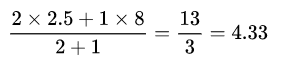
Hence, given n items, to implement Slope One, all that is needed is to compute and store the average differences and the number of common ratings for each of the n^2 pairs of items.

In [42]:
kf = KFold(n_splits=3)
SlopeOnealgo = SlopeOne()

for trainset, testset in kf.split(data):
    # train and test algorithm.
    SlopeOnealgo.fit(trainset)
    predictions = SlopeOnealgo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 1.1453
RMSE: 1.1469
RMSE: 1.1289


In [45]:
kf = KFold(n_splits=3)
CoClusteringalgo = CoClustering()

for trainset, testset in kf.split(data):
    # train and test algorithm.
    CoClusteringalgo.fit(trainset)
    predictions = CoClusteringalgo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 1.1416
RMSE: 1.1598
RMSE: 1.1474


### DIMSUM - Similarity

The main disadvantage with Cosine Similarity recommendation systems is the complexity. It’s of the order O(n2), which means, if we are to use the recommendation system on a dataset of a million, it would take up to a billion complexity. That’s were DIMSUM comes into place, it uses MapReduce functionality in effectively calculating the Cosine Similarity. DIMSUM, an efficient and accurate all-pair similarity algorithm for real-world large-scale dataset, tackles shuffle size problem of several similarity measures using MapReduce. The algorithm uses a sampling technique to reduce `power items' and preserves similarities. 
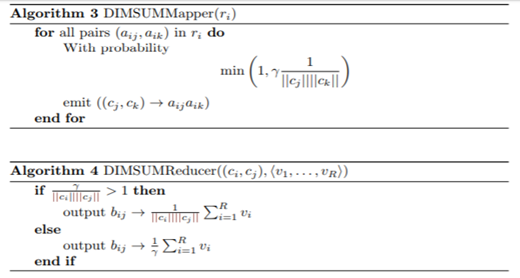
We usually pick, ɣ = 4 log(n)/s, where s is our desired similarity threshold. We see below the cosine similarity between different items.

In [14]:
if(readData):
    sparkdf = spark.read.json(data_loc)
    sparkdf = sparkdf.limit(50000)
    sparkdf = sparkdf.drop("helpful").drop("reviewText").drop("reviewTime")\
                .drop("reviewerName").drop("summary").drop("unixReviewTime")
    
    indexer = StringIndexer(inputCol="reviewerID", outputCol="reviewerIDIndex")
    indexed = indexer.fit(sparkdf).transform(sparkdf)
    indexed.write.parquet("indexed.parquet")
    
    indexer = StringIndexer(inputCol="asin", outputCol="productIDIndex")
    data_df = indexer.fit(indexed).transform(indexed)
    data_df = data_df.drop("asin").drop("reviewerID")
    data_df.write.parquet("data_df.parquet")
else:
    data_df = sqlContext.read.parquet("data_df.parquet")
    
data_df.head()

Row(overall=4.0, reviewerIDIndex=19306.0, productIDIndex=779.0)

In [47]:
mat = CoordinateMatrix(data_df.rdd.map(lambda r: MatrixEntry(r.reviewerIDIndex, r.productIDIndex, r.overall)))
data = mat.toRowMatrix()

In [48]:
dimsumSim = data.columnSimilarities()

In [84]:
dimsumSim.entries.take(10)

[MatrixEntry(656, 696, 0.22070377226756643),
 MatrixEntry(68, 111, 0.008702518557846753),
 MatrixEntry(133, 185, 0.03351579845910721),
 MatrixEntry(1, 354, 0.0010249521012127125),
 MatrixEntry(19, 37, 0.1184806933609093),
 MatrixEntry(81, 752, 0.05810905840484827),
 MatrixEntry(265, 274, 0.061014186837638575),
 MatrixEntry(74, 166, 0.014327826471018686),
 MatrixEntry(133, 391, 0.053350977640947934),
 MatrixEntry(35, 379, 0.022786907451052583)]

### ALS

Alternating Least Square Errors (ALS)
Alternating Least Square Errors is a Collaborative Filtering based matrix factorization technique. We use the Machine Learning technique to factorize the rating matrix. We fix relatively a small value k and summarize each user with a k dimensional vector. Then to predict user u’s rating for item I, we simply predict rui by approximating it to xuTyi. We can formulate this as an optimization problem in which we aim to minimize the least squared error of the observed ratings. This optimization problem can be given as:
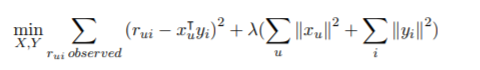
We got the best performance with rank 20 and iteration 15, however, with higher rank and higher iteration we get low performance.
By comparing all the above recommendation systems, by far we get lower RMSE value for ALS recommendation system. This gives us a good start to know about various recommendation systems and their performance on various parameters.


In [15]:
data_df.createOrReplaceTempView("amznratings")

In [16]:
ratingsDF = spark.sql("SELECT productIDIndex, reviewerIDIndex, overall FROM amznratings")
ratingsDF.head(5)

[Row(productIDIndex=779.0, reviewerIDIndex=19306.0, overall=4.0),
 Row(productIDIndex=779.0, reviewerIDIndex=22687.0, overall=5.0),
 Row(productIDIndex=779.0, reviewerIDIndex=30359.0, overall=5.0),
 Row(productIDIndex=779.0, reviewerIDIndex=12302.0, overall=5.0),
 Row(productIDIndex=779.0, reviewerIDIndex=41135.0, overall=3.0)]

In [17]:
ratingsDF.count()

50000

In [18]:
[mean, min, max] = ratingsDF.select([mean('overall').alias("mean"), min('overall').alias("min"), max('overall').alias("max")]).collect()[0]

In [19]:
print("Mean Score ", mean)
print("Minimum Score ", min)
print("Maximum Score ", max)

Mean Score  4.30016
Minimum Score  1.0
Maximum Score  5.0


In [20]:
quantile = ratingsDF.approxQuantile('overall', [0.5], 0.25)

In [21]:
print("Meadian Score ", quantile)

Meadian Score  [4.0]


In [22]:
rating = ratingsDF.rdd.map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))

In [23]:
def ALS_Spark(iterations, rank):
    rank = rank
    numIterations = iterations
    model = ALS.train(rating, rank, numIterations)
    testdata = rating.map(lambda p: (p[0], p[1]))
    predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
    ratesAndPreds = rating.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)

    MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
    RMSE = np.sqrt(MSE)
    print("Using number of ranks = ", rank)
    print("Using number of iterations = ", numIterations)
    print("Mean Squared Error = " + str(MSE))
    return RMSE

In [73]:
numIterations = [5, 10, 20]
ranks = [2,5,10,20]
MSE_results = []

for rank in ranks:
    for iterations in numIterations:
        MSE_results.append(ALS_Spark(iterations, rank))

Using number of ranks =  2
Using number of iterations =  5
Mean Squared Error = 0.119071649662
RMSE =  0.345067601582  

Using number of ranks =  2
Using number of iterations =  10
Mean Squared Error = 0.119071649337
RMSE =  0.345067601112  

Using number of ranks =  2
Using number of iterations =  20
Mean Squared Error = 0.119071649334
RMSE =  0.345067601107  

Using number of ranks =  5
Using number of iterations =  5
Mean Squared Error = 0.119071649669
RMSE =  0.345067601593  

Using number of ranks =  5
Using number of iterations =  10
Mean Squared Error = 0.119071649334
RMSE =  0.345067601107  

Using number of ranks =  5
Using number of iterations =  20
Mean Squared Error = 0.119071649328
RMSE =  0.345067601098  

Using number of ranks =  10
Using number of iterations =  5
Mean Squared Error = 0.119071649673
RMSE =  0.345067601599  

Using number of ranks =  10
Using number of iterations =  10
Mean Squared Error = 0.119071649336
RMSE =  0.345067601111  

Using number of ranks =  

### Future Work - Serendipity

Over the past several years, research in recommender systems has emphasized the importance of serendipity, but there is still no consensus on the definition of this concept and whether serendipitous items should be recommended is still not a well-addressed question. According to the most common definition, serendipity consists of three components: relevance, novelty and unexpectedness, where each component has multiple variations. There are two main reasons for collaborative recommender systems to suggest serendipitous items: they broaden user preferences and increase user satisfaction.<br/>
Researchers often indicate that serendipitous items are very rare. However, it is unclear exactly how rare these items are, as it might not be worth of suggesting them due to their rareness and a high risk of suggesting irrelevant items, while optimizing for serendipity. An item is relevant to a user if the user expresses or will express their preference for the item in the future by liking or consuming the item depending on the application scenario. Novelty of an item to a user depends on how familiar the user is with the item. An item can be novel to a user in different ways: 
-	The user has never heard about the item.
-	The user has heard about the item, but has not consumed it.
-	The user has consumed the item and forgot about it.
<br/><br/>Studies on serendipity in recommender systems often neglect the definition of unexpectedness. We present many definitions corresponding to the component. An item can be unexpected to the user if: <br/>
-	The user does not expect this item to be relevant to them.
-	The user does not expect this item to be recommended to them.
-	The user would not have found this item on their own.
-	The item is significantly dissimilar to items the user usually consumes.
-	The user does not expect to find this item, as the user is looking for other kinds of items.<br/><br/>
We plan to implement serendipity in our recommendation system by using the Linked Open Data. Generally, serendipity would work in a way that if a user likes Data Mining, the recommendation system generates the below link and in turn recommends HMM to the user.<br/><br/>
Data Mining   ->   Machine Learning   ->   NLP   ->   Topic Modeling   ->   HMM<br/><br/>
Serendipity is a very interesting and challenging task in recommendation systems and we would like to explore more about them in future.
